# read all forcings and interpolate using model algorithm and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas

In [2]:
# make all plots larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 8]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300

In [9]:
# color scheme

# MLD
#FFDE00 Silicate
#575756 Nitrate
#009640 Phytoplankton
#EA5B0C Mikrozooplankton
#BE1622 Mesozooplankton
#B17F4A Detritus
#DEDC00 SST
#F9B233 PAR

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colormap = pandas.DataFrame({"name" : ["MLD", "Si", "N", "Phyto", "MikroZ", "MesoZ", "D", "SST", "PAR"],
                         "color" : ["#1D71B8", "#FFDE00", "#575756", "#009640", "#EA5B0C", "#BE1622", "#B17F4A", "#E94E1B", "#F9B233"]})

colormap["name"] = colormap["name"].apply(lambda x: x.lower())   
c = dict(zip(*colormap.values.T))
mcolors.get_named_colors_mapping().update(c)

In [31]:
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    # tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    # newt = np.mod(time, 365.)
    tmonth = np.linspace(-.5, 12.5, 14) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(-.5, 12.5, 14) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [64]:
tmonth = np.linspace(-15., 365.+15, 14) #HERE deprecation warning due to 13. <- float, should be int
newt = np.mod(1, 365.)
print(tmonth)
print(newt)
outintp = intrp.UnivariateSpline(tmonth, MLD, k=kmld, s=smld)
print(outintp.derivative()(newt))

[-15.          15.38461538  45.76923077  76.15384615 106.53846154
 136.92307692 167.30769231 197.69230769 228.07692308 258.46153846
 288.84615385 319.23076923 349.61538462 380.        ]
1.0
0.21476949099815332


In [57]:
tmonth = np.linspace(-.5, 12.5, 14) #HERE again, deprecation warning
newt = np.mod(3, 365.) * 12. / 365.
print(tmonth)
print(newt)
outintp = intrp.UnivariateSpline(tmonth, MLD, k=kmld, s=smld)
print(outintp(newt))

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5]
0.09863013698630137
34.4443776944156


In [11]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "PWPoly"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "PWPoly"

In [12]:
# read environmental forcings
MLDfile = pandas.read_csv('MLD2015_R1.csv')

NOXfile = pandas.read_csv('NO2NO3_R1.csv')

SiOXfile = pandas.read_csv('SiOH_R1.csv')

SSTfile = pandas.read_csv('SST_R1.csv')

PARfile = pandas.read_csv('PAR_R1.csv')

## important choice here:
# mean or median of monthly values

In [23]:
MLD_monthly_median = MLDfile.groupby('month').mean() 
MLDoneyear = list(MLD_monthly_median['MLD'])
MLD = [MLDoneyear[11]] + MLDoneyear + [MLDoneyear[0]]
#MLD.append(MLD[0])

NOX_monthly_median = NOXfile.groupby('month').mean() 
NOXoneyear = list(NOX_monthly_median['NO2NO3'])
NOX = [NOXoneyear[11]] + NOXoneyear + [NOXoneyear[0]]
#NOX.append(NOX[0])

SiOX_monthly_median = SiOXfile.groupby('month').mean() 
SiOXoneyear = list(SiOX_monthly_median['SiOH'])
SiOX = [SiOXoneyear[11]] + SiOXoneyear + [SiOXoneyear[0]]
#SiOX.append(SiOX[0])

SST_monthly_median = SSTfile.groupby('month').mean()
SSToneyear = list(SST_monthly_median['SST'])
SST = [SSToneyear[11]] + SSToneyear + [SSToneyear[0]]
#SST.append(SST[0])

PAR_monthly_median = PARfile.groupby('month').mean()
PARoneyear = list(PAR_monthly_median['PAR'])
PAR = [PARoneyear[11]] + PARoneyear + [PARoneyear[0]]
#PAR.append(PAR[0])

0.0031953095249375655


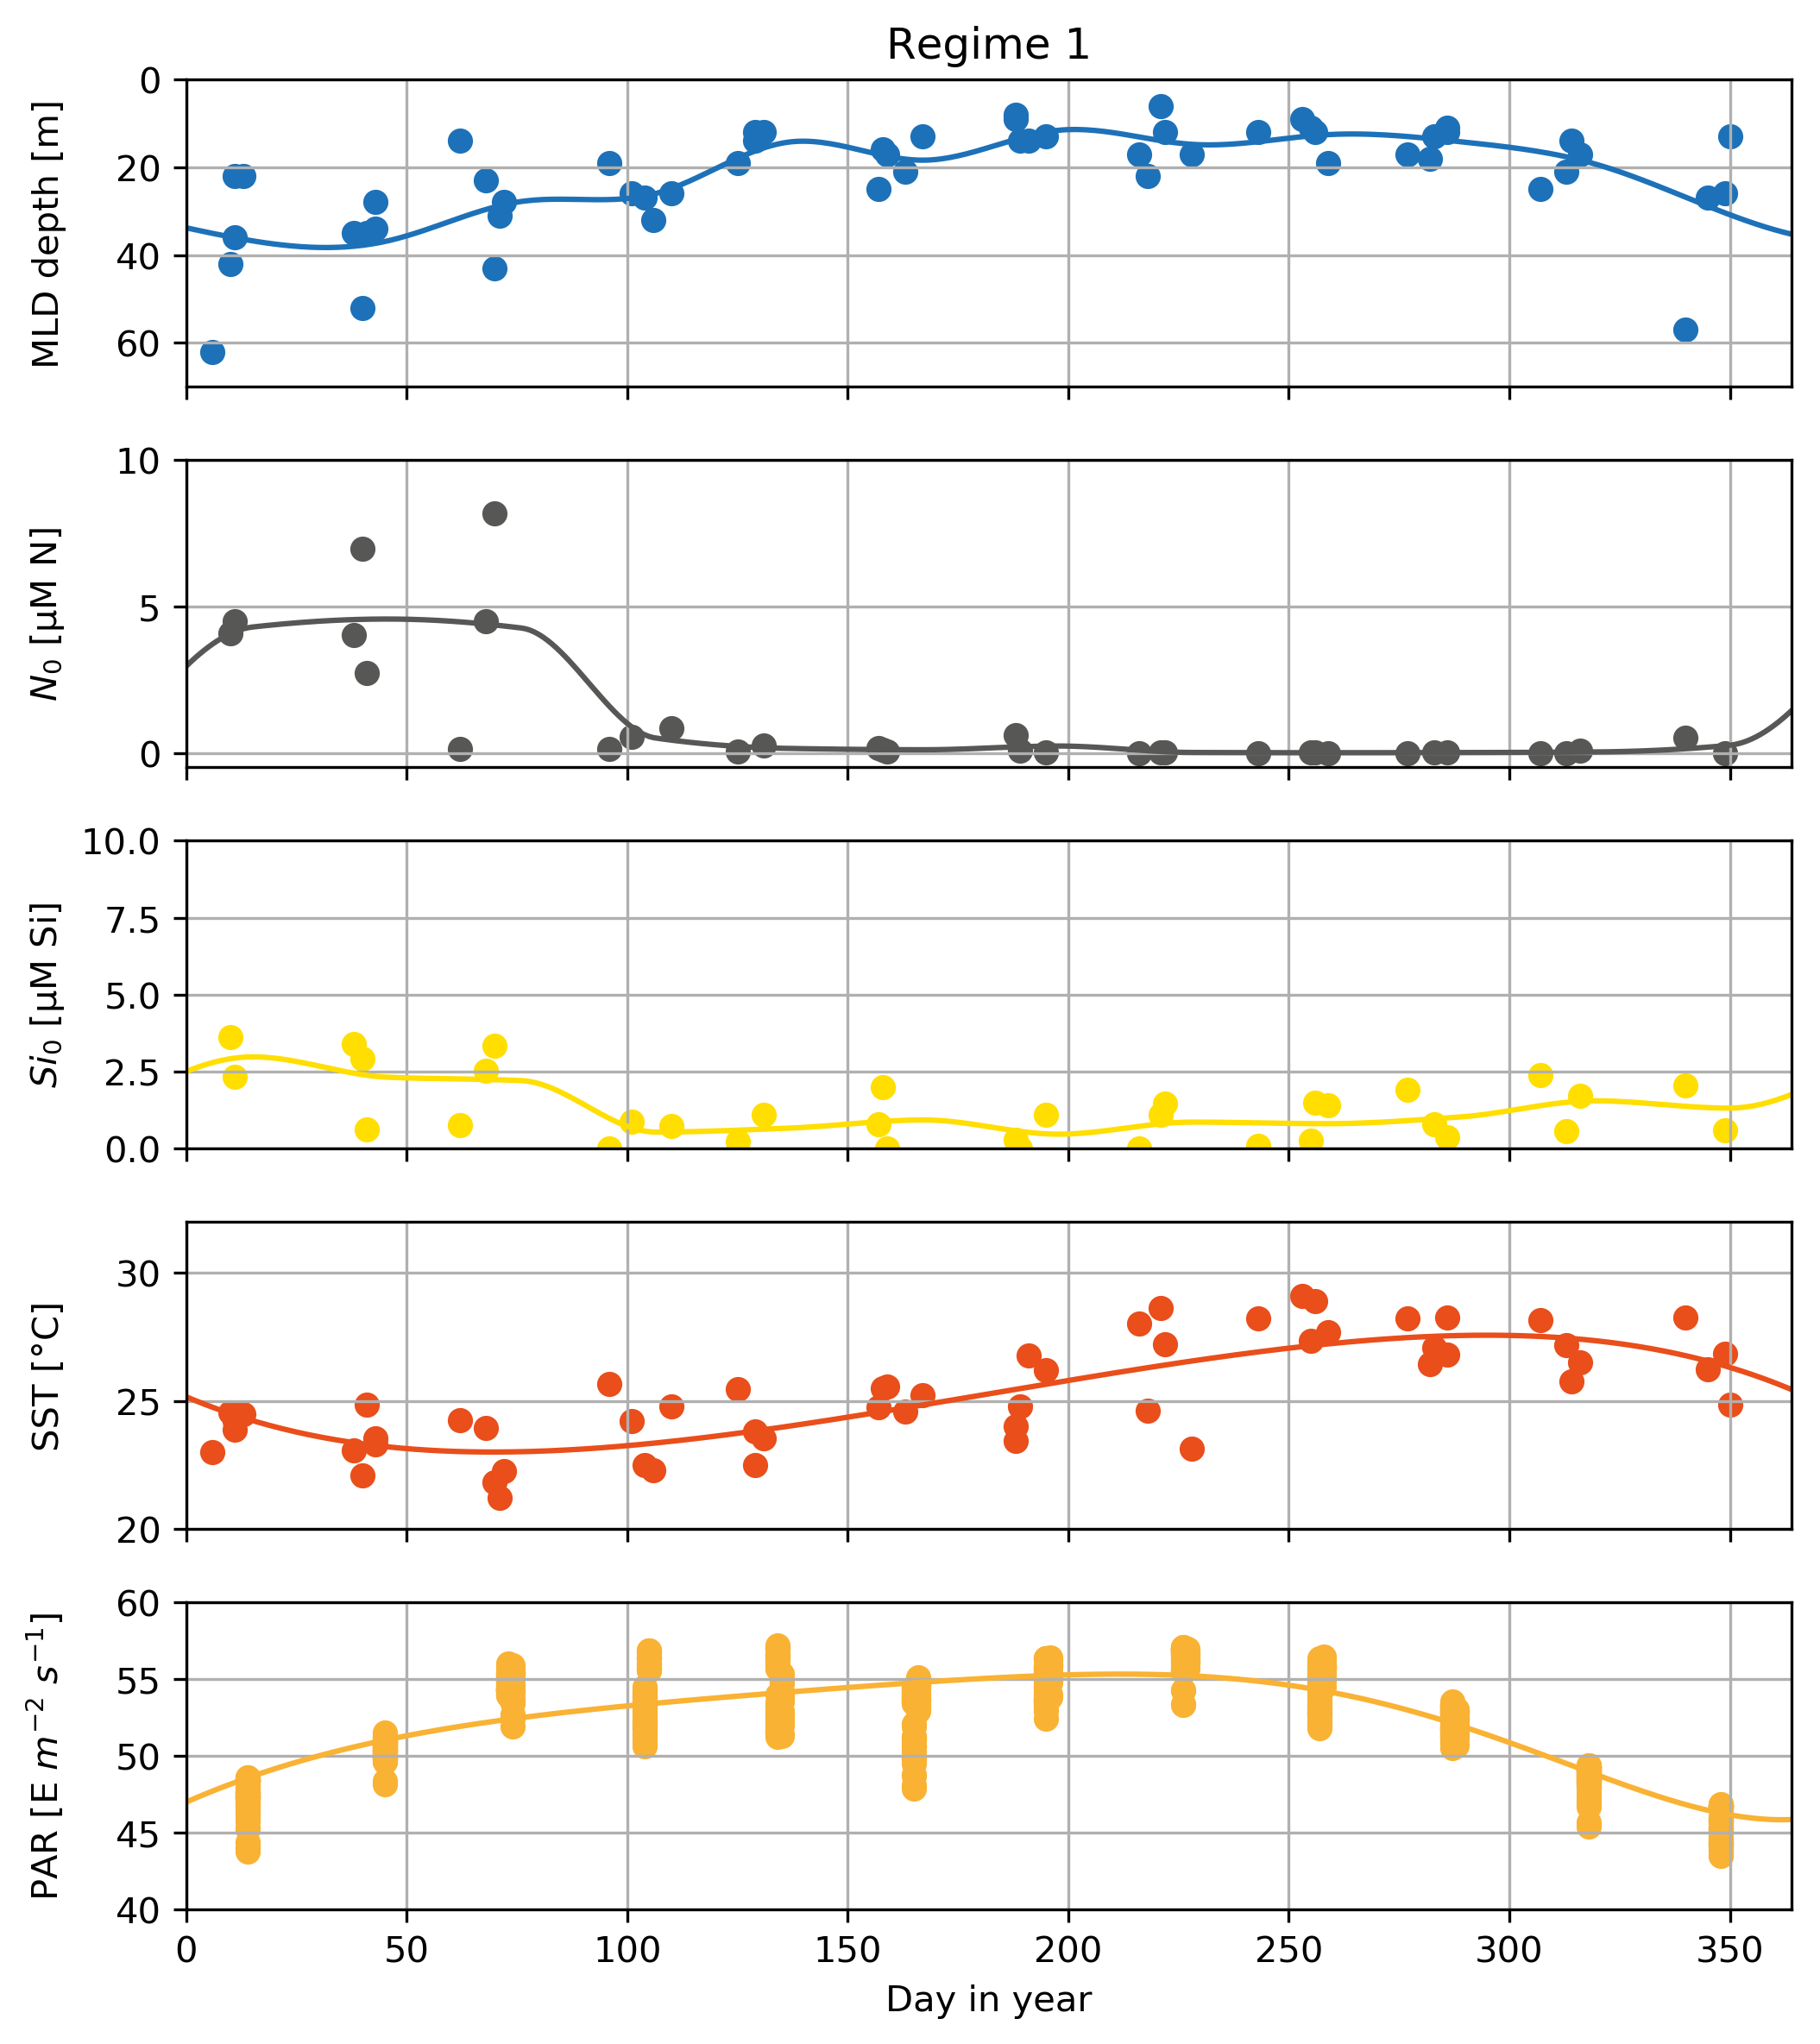

In [65]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD = dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)

forcing_NOX = dailyinterp(NOX, t_forcingplot, kind=kindn0x, k=kn0x, s=sn0x)

forcing_SiOX = dailyinterp(SiOX, t_forcingplot, kind=kindsi0x, k=ksi0x, s=ssi0x)

forcing_SST = dailyinterp(SST, t_forcingplot, kind=kindsst, k=ksst, s=ssst)

forcing_PAR = dailyinterp(PAR, t_forcingplot, kind=kindpar, k=kpar, s=spar)

print(min(forcing_NOX))

fig, (fx1, fx2, fx3, fx4, fx5) = plt.subplots(5, 1, sharex='col', sharey='row')
# MLD
fx1.plot(t_forcingplot, forcing_MLD, color='MLD')
fx1.scatter(MLDfile['yday'], MLDfile['MLD'], color='MLD')
fx1.set_ylim(0,70)
fx1.set_ylabel('MLD depth [m]')
fx1.set_title('Regime 1')
fx1.invert_yaxis()
fx1.grid()

# NOX
fx2.plot(t_forcingplot, forcing_NOX, color='N')
fx2.scatter(NOXfile['yday'], NOXfile['NO2NO3'], color='N')
fx2.set_ylim(-0.5,10)
fx2.set_ylabel('$N_0$ [µM N]')
fx2.grid()

# SiOX
fx3.plot(t_forcingplot, forcing_SiOX, color='Si')
fx3.scatter(SiOXfile['yday'], SiOXfile['SiOH'], color='Si')
fx3.set_ylim(0,10)
fx3.set_ylabel('$Si_0$ [µM Si]')
fx3.grid()

# SST
fx4.set_ylabel('SST [°C]')
fx4.plot(t_forcingplot, forcing_SST, color='SST')
fx4.scatter(SSTfile['yday'], SSTfile['SST'], color='SST')
fx4.set_ylim(20,32)
fx4.grid()

# PAR
fx5.set_ylabel('PAR [E $m^{−2}$ $s^{−1}$]')
fx5.plot(t_forcingplot, forcing_PAR, color='PAR')
fx5.scatter(PARfile['yday'], PARfile['PAR'], color='PAR')
fx5.set_ylim(40,60)
fx5.grid()


fx5.set_xlabel('Day in year')

fig.align_ylabels()
plt.margins(x=0)
plt.tight_layout()
plt.savefig('FORCING_R1.png')
plt.show()

#titles on the side!
#labels as big as possible
#more numbers on axis (major ticks + minor ticks)
#lines thicker
#plot original data with interpolation (scattered raw data (or average +- bars, standard errors)), perhaps boxplots or cut off top
#put letters size all the same
# put NO2+NO3 instead of N, for all chemicals
# start on origin, no gaps

In [25]:
# read environmental forcings
MLD2file = pandas.read_csv('MLD2015_R2.csv')

NOX2file = pandas.read_csv('NO2NO3_R2.csv')

SiOX2file = pandas.read_csv('SiOH_R2.csv')

SST2file = pandas.read_csv('SST_R2.csv')

PAR2file = pandas.read_csv('PAR_R2.csv')

## important choice here:
# mean or median of monthly values

In [26]:
MLD2_monthly_median = MLD2file.groupby('month').mean() 
MLD2oneyear = list(MLD2_monthly_median['MLD'])
MLD2 = [MLD2oneyear[11]] + MLD2oneyear + [MLD2oneyear[0]]
#MLD.append(MLD[0])

NOX2_monthly_median = NOX2file.groupby('month').mean() 
NOX2oneyear = list(NOX2_monthly_median['NO2NO3'])
NOX2 = [NOX2oneyear[11]] + NOX2oneyear + [NOX2oneyear[0]]
#NOX.append(NOX[0])

SiOX2_monthly_median = SiOX2file.groupby('month').mean() 
SiOX2oneyear = list(SiOX2_monthly_median['SiOH'])
SiOX2 = [SiOX2oneyear[11]] + SiOX2oneyear + [SiOX2oneyear[0]]
#SiOX.append(SiOX[0])

SST2_monthly_median = SST2file.groupby('month').mean()
SST2oneyear = list(SST2_monthly_median['SST'])
SST2 = [SST2oneyear[11]] + SST2oneyear + [SST2oneyear[0]]
#SST.append(SST[0])

PAR2_monthly_median = PAR2file.groupby('month').mean()
PAR2oneyear = list(PAR2_monthly_median['PAR'])
PAR2 = [PAR2oneyear[11]] + PAR2oneyear + [PAR2oneyear[0]]
#PAR.append(PAR[0])

In [27]:
PAR2

[45.14934903339599,
 46.57689910120098,
 51.9452993561863,
 53.334532755504675,
 53.47769942897139,
 52.94116607015408,
 53.466749428451294,
 52.75579939468298,
 54.43725947454804,
 52.80459939700086,
 49.479849239083705,
 47.8050391595345,
 45.14934903339599,
 46.57689910120098]

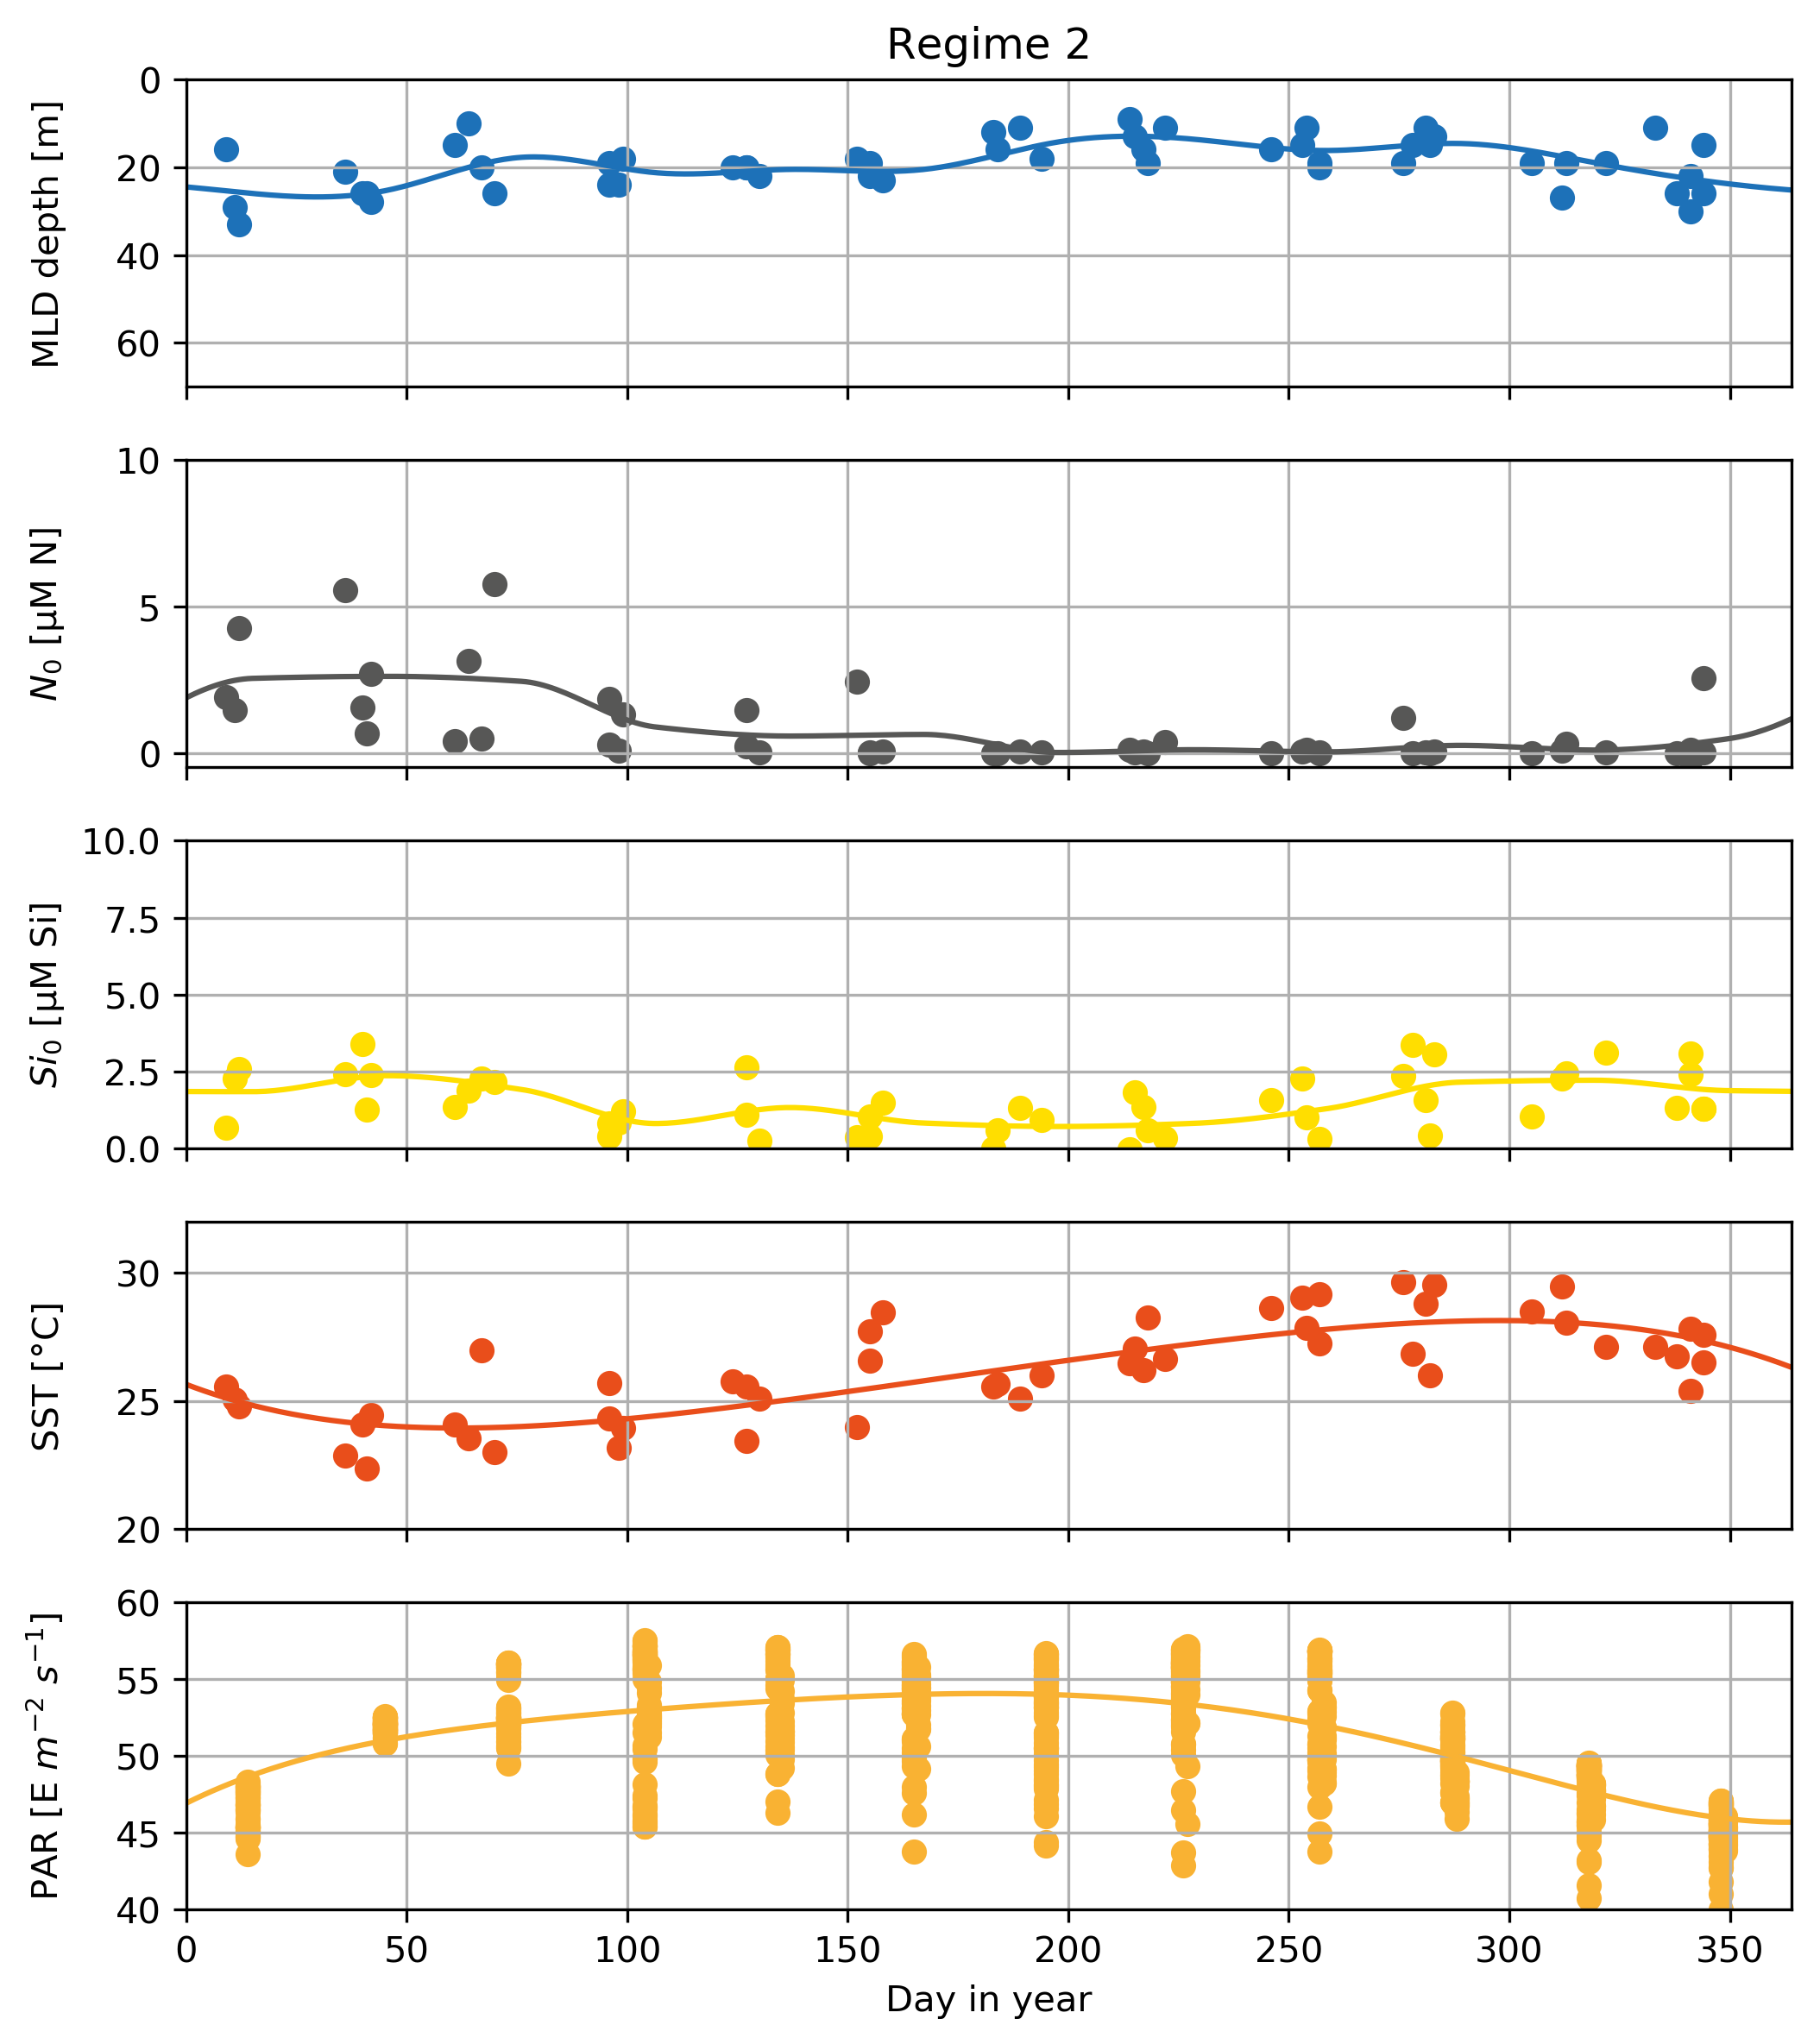

In [66]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD2 = dailyinterp(MLD2, t_forcingplot, kind=kindmld, k=kmld, s=smld)

forcing_NOX2 = dailyinterp(NOX2, t_forcingplot, kind=kindn0x, k=kn0x, s=smld)

forcing_SiOX2 = dailyinterp(SiOX2, t_forcingplot, kind=kindsi0x, k=ksi0x, s=ssi0x)

forcing_SST2 = dailyinterp(SST2, t_forcingplot, kind=kindsst, k=ksst, s=ssst)

forcing_PAR2 = dailyinterp(PAR2, t_forcingplot, kind=kindpar, k=kpar, s=spar)#, kind=kindpar, k=kpar, s=spar)



fig, (fx1, fx2, fx3, fx4, fx5) = plt.subplots(5, 1, sharex='col', sharey='row')
# MLD
fx1.plot(t_forcingplot, forcing_MLD2, color='MLD')
fx1.scatter(MLD2file['yday'], MLD2file['MLD'], color='MLD')
fx1.set_ylim(0,70)
fx1.set_ylabel('MLD depth [m]')
fx1.set_title('Regime 2')
fx1.invert_yaxis()
fx1.grid()

# NOX
fx2.plot(t_forcingplot, forcing_NOX2, color='N')
fx2.scatter(NOX2file['yday'], NOX2file['NO2NO3'], color='N')
fx2.set_ylim(-0.5,10)
fx2.set_ylabel('$N_0$ [µM N]')
fx2.grid()

# SiOX
fx3.plot(t_forcingplot, forcing_SiOX2, color='Si')
fx3.scatter(SiOX2file['yday'], SiOX2file['SiOH'], color='Si')
fx3.set_ylim(0,10)
fx3.set_ylabel('$Si_0$ [µM Si]')
fx3.grid()

# SST
fx4.set_ylabel('SST [°C]')
fx4.plot(t_forcingplot, forcing_SST2, color='SST')
fx4.scatter(SST2file['yday'], SST2file['SST'], color='SST')
fx4.set_ylim(20,32)
fx4.grid()

# PAR
fx5.plot(t_forcingplot, forcing_PAR2, color='PAR')
fx5.scatter(PAR2file['yday'], PAR2file['PAR'], color='PAR')
fx5.set_ylim(40,60)
fx5.set_ylabel('PAR [E $m^{−2}$ $s^{−1}$]')
fx5.grid()


fx5.set_xlabel('Day in year')

fig.align_ylabels()
plt.margins(x=0)
plt.tight_layout()
plt.savefig('FORCING_R2.png')
plt.show()

# PLOT DERIVATIVE OF MLD DEPTH FOR BOTH REGIMES

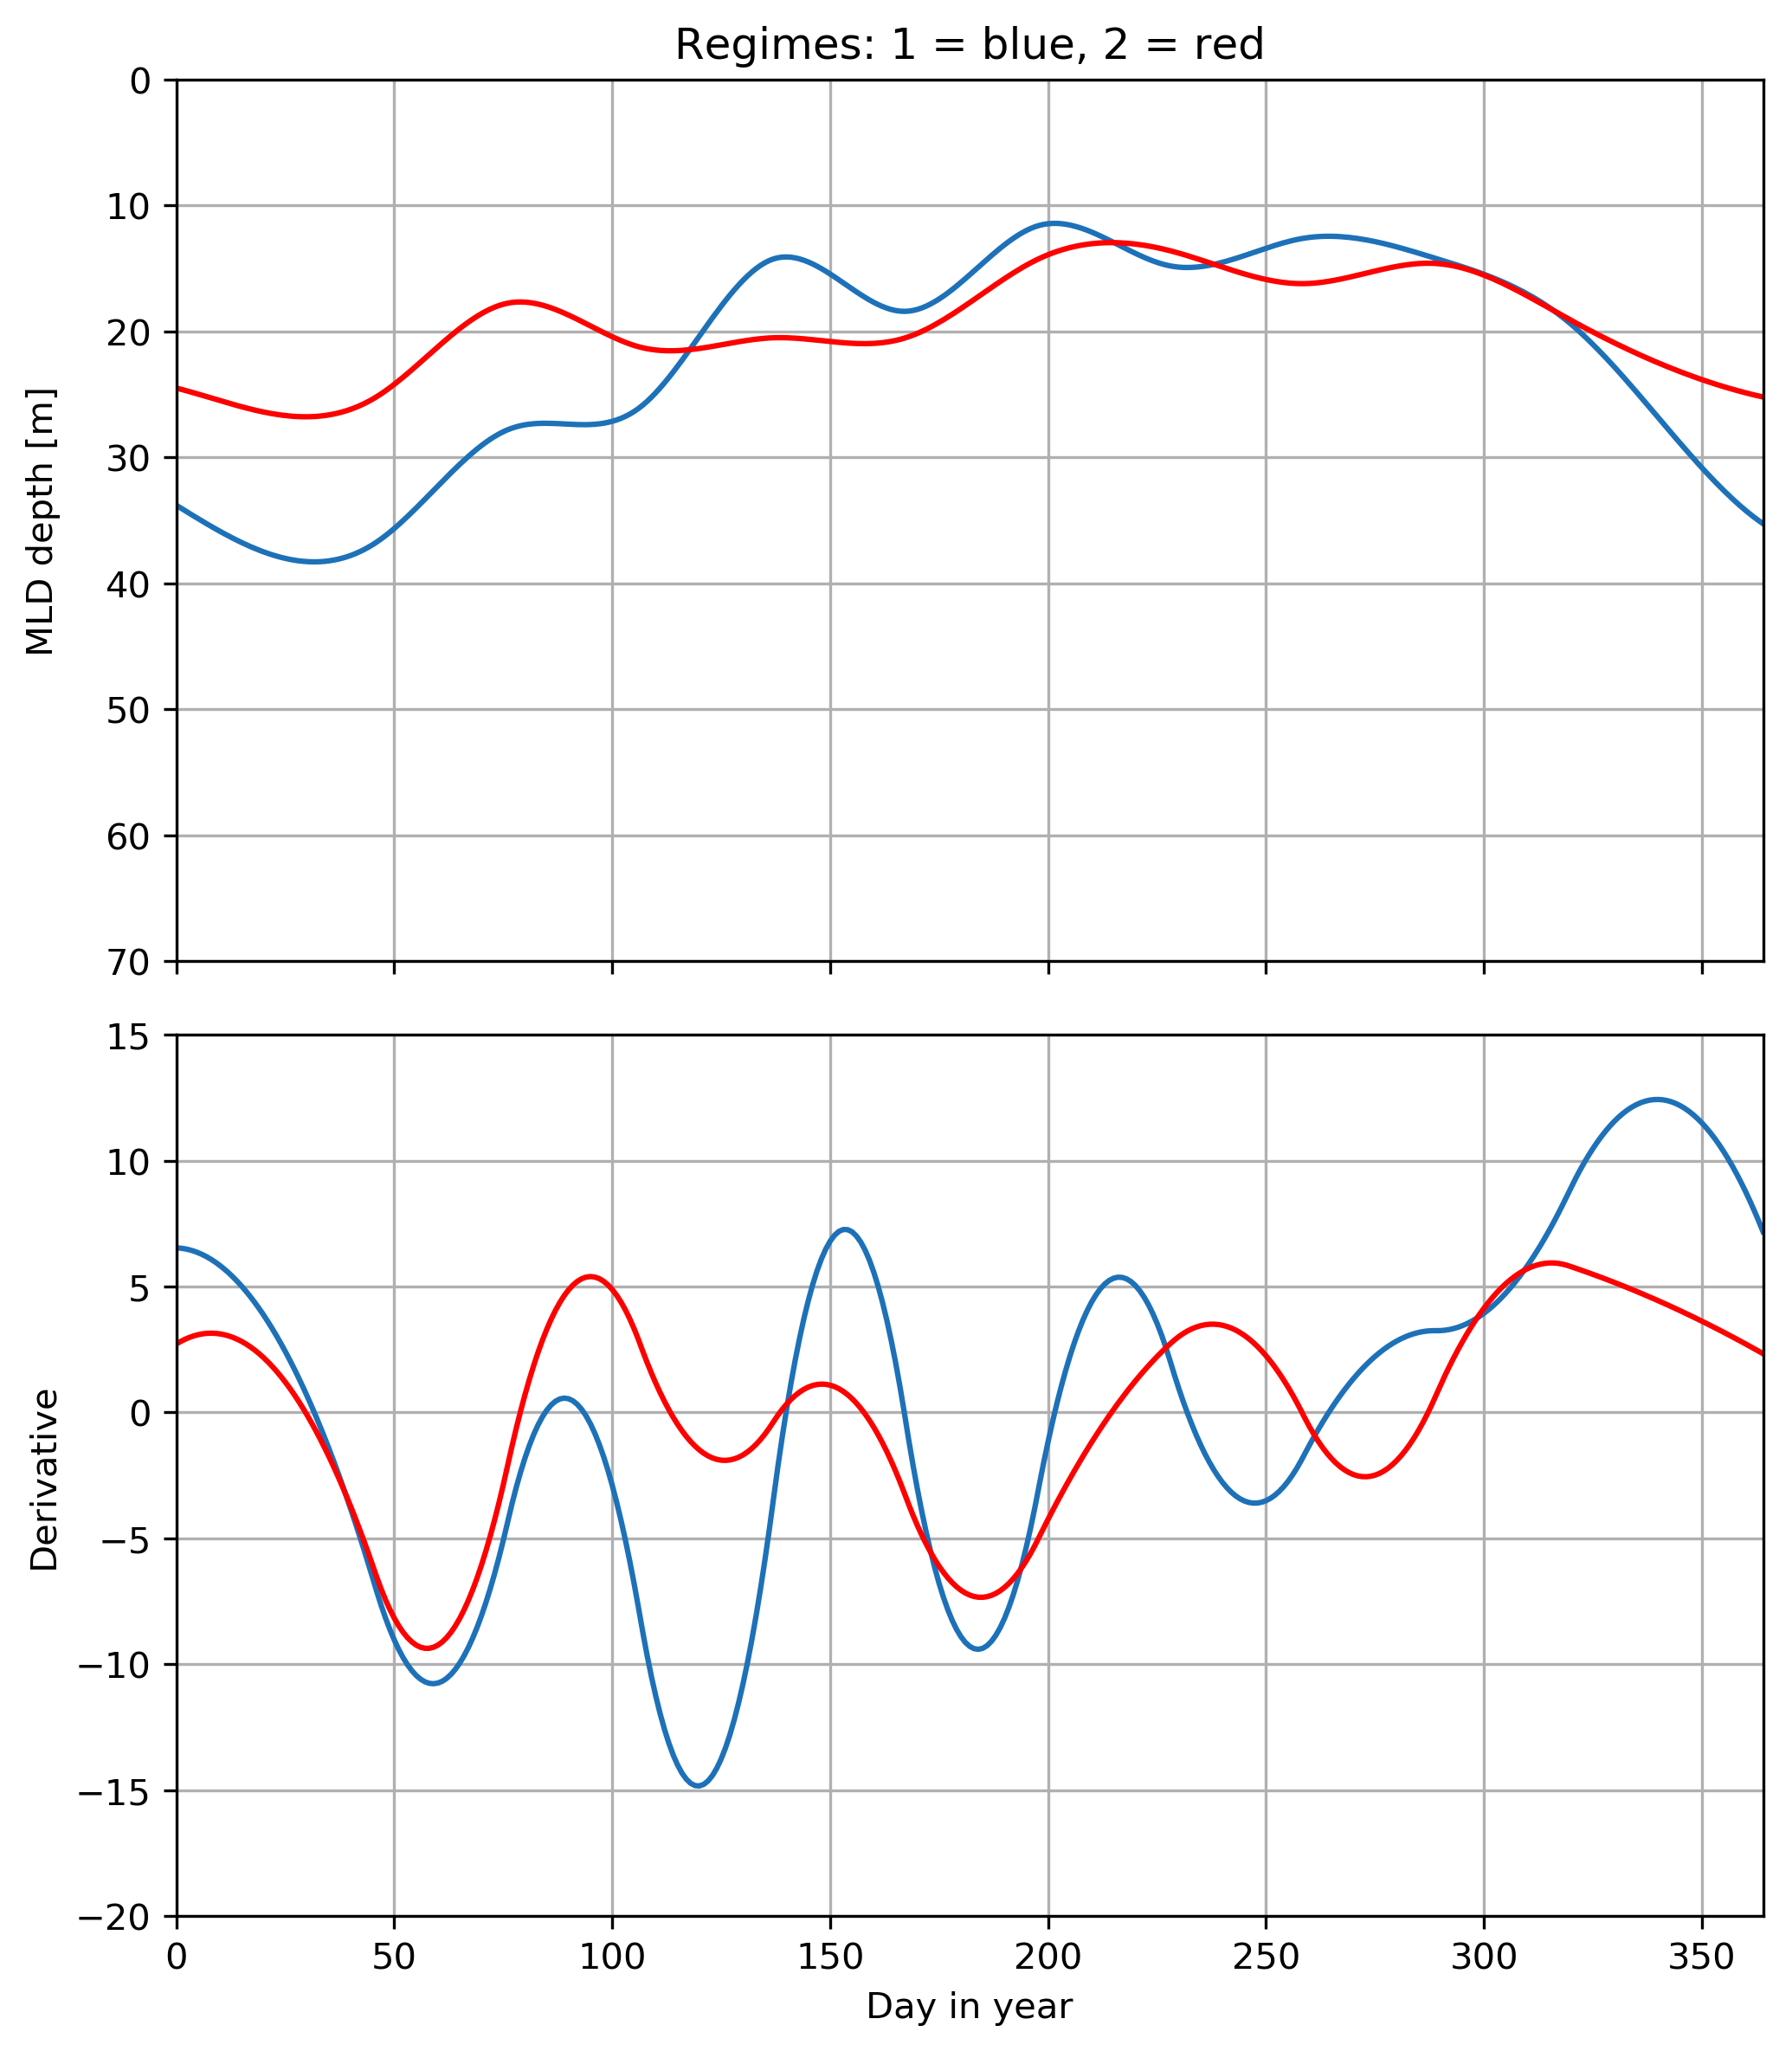

In [46]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD = dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_MLD2 = dailyinterp(MLD2, t_forcingplot, kind=kindmld, k=kmld, s=smld)

deriv_MLD = firstderivspl(MLD, t_forcingplot, k=kmld, s=smld)
deriv_MLD2 = firstderivspl(MLD2, t_forcingplot, k=kmld, s=smld)

fig, (fx1, fx2) = plt.subplots(2, 1, sharex='col', sharey='row')

# both plotted on top of each other
fx1.plot(t_forcingplot, forcing_MLD, color='MLD')
fx1.plot(t_forcingplot, forcing_MLD2, color='red')
fx1.set_ylim(0,70)
fx1.set_ylabel('MLD depth [m]')
fx1.set_title('Regimes: 1 = blue, 2 = red')
fx1.invert_yaxis()
fx1.grid()

# both derivatives
fx2.plot(t_forcingplot, deriv_MLD, color='MLD')
fx2.plot(t_forcingplot, deriv_MLD2, color='red')
fx2.set_ylim(-20,15)
fx2.set_ylabel('Derivative')
fx2.grid()

fx2.set_xlabel('Day in year')

fig.align_ylabels()
plt.margins(x=0)
plt.savefig('regimecomparison.png')
plt.tight_layout()

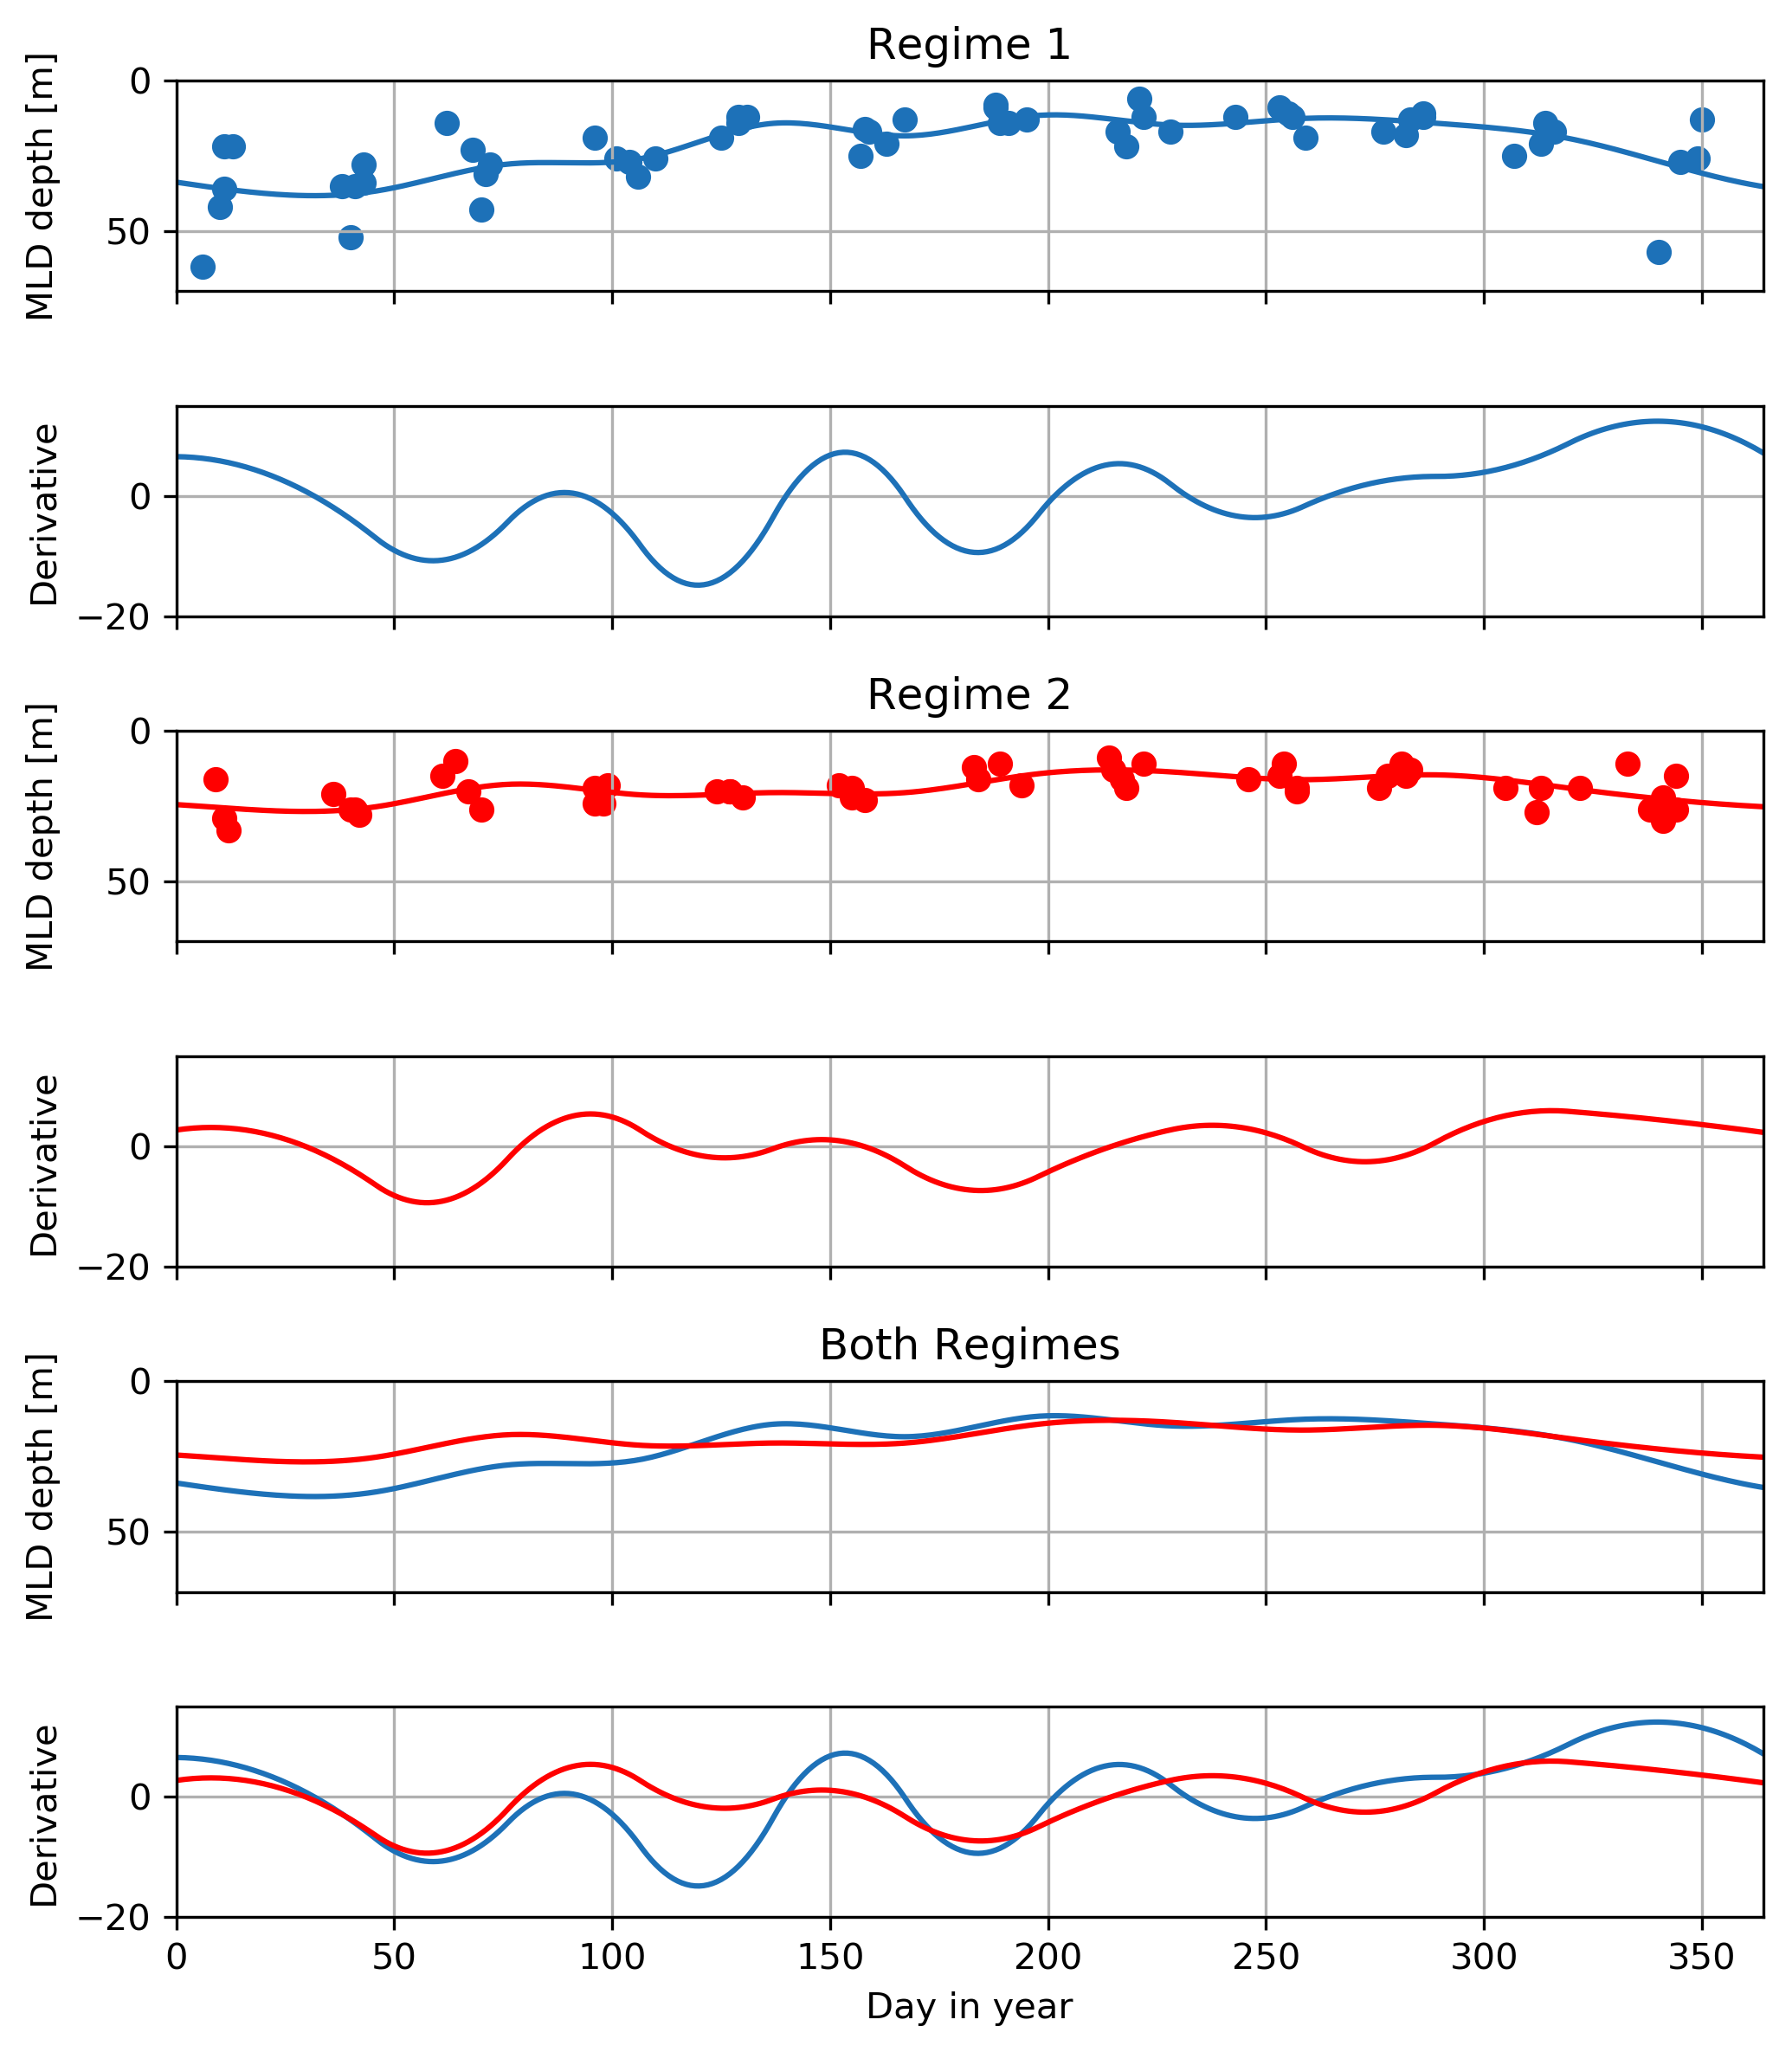

In [44]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD = dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_MLD2 = dailyinterp(MLD2, t_forcingplot, kind=kindmld, k=kmld, s=smld)

deriv_MLD = firstderivspl(MLD, t_forcingplot, k=kmld, s=smld)
deriv_MLD2 = firstderivspl(MLD2, t_forcingplot, k=kmld, s=smld)

fig, (fx1, fx2, fx3, fx4, fx5, fx6) = plt.subplots(6, 1, sharex='col', sharey='row')

# MLD 1
fx1.plot(t_forcingplot, forcing_MLD, color='MLD')
fx1.scatter(MLDfile['yday'], MLDfile['MLD'], color='MLD')
fx1.set_ylim(0,70)
fx1.set_ylabel('MLD depth [m]')
fx1.set_title('Regime 1')
fx1.invert_yaxis()
fx1.grid()

# MLD deriv 1
fx2.plot(t_forcingplot, deriv_MLD, color='MLD')
fx2.set_ylim(-20,15)
fx2.set_ylabel('Derivative')
fx2.grid()

# MLD 2
fx3.plot(t_forcingplot, forcing_MLD2, color='red')
fx3.scatter(MLD2file['yday'], MLD2file['MLD'], color='red')
fx3.set_ylim(0,70)
fx3.set_ylabel('MLD depth [m]')
fx3.set_title('Regime 2')
fx3.invert_yaxis()
fx3.grid()

# MLD deriv 2
fx4.plot(t_forcingplot, deriv_MLD2, color='red')
fx4.set_ylim(-20,15)
fx4.set_ylabel('Derivative')
fx4.grid()

# both plotted on top of each other
fx5.plot(t_forcingplot, forcing_MLD, color='MLD')
fx5.plot(t_forcingplot, forcing_MLD2, color='red')
fx5.set_ylim(0,70)
fx5.set_ylabel('MLD depth [m]')
fx5.set_title('Both Regimes')
fx5.invert_yaxis()
fx5.grid()

# both derivatives
fx6.plot(t_forcingplot, deriv_MLD, color='MLD')
fx6.plot(t_forcingplot, deriv_MLD2, color='red')
fx6.set_ylim(-20,15)
fx6.set_ylabel('Derivative')
fx6.grid()

fx6.set_xlabel('Day in year')

fig.align_ylabels()
plt.margins(x=0)
plt.tight_layout()